# Xception
- CIFAR10 dataset is used to train the pre-trained model **Xception**. 
- Only the labelled dataset is used in this model.
- Fine-tuning of the model is also done, through freezing the layer, adding new layers to the model etc.

# Importing the Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tabulate import tabulate
from sklearn.metrics import accuracy_score, log_loss

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception

In [2]:
# Making sure that Tensorflow is able to detect the GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Defining a function to list the memory consumed
# Only outputs variables taking at least 1MB space
def list_storage(inp_dir):
    # Get a sorted list of the objects and their sizes
    vars_defined = [x for x in inp_dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    sto = sorted([(x, sys.getsizeof(globals().get(x))) for x in vars_defined], key=lambda x: x[1], reverse=True)
    sto = [(x[0], str(round((x[1] / 2**20), 2)) + ' MB') for x in sto if x[1] >= 2**20]
    print(tabulate(sto, headers = ['Variable', 'Storage (in MB)']))

# In order to use this function, use the below line of code
# list_storage(dir())

In [4]:
# Importing the Labelled Dataset
df_train = pd.read_csv("../input/cifar10/train_lab_x.csv")
y_train = pd.read_csv("../input/cifar10/train_lab_y.csv")

# Importing the Test Dataset
df_test = pd.read_csv("../input/cifar10/test_x.csv")
y_test = pd.read_csv("../input/cifar10/test_y.csv")

# Basic Pre-processing

(40006, 3072) (40006, 1)
(40006, 3, 32, 32)
[0]


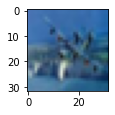

In [5]:
df_train = np.array(df_train)
y_train = np.array(y_train)
print(df_train.shape, y_train.shape)

# Reshaping the dataset
df_train = np.reshape(df_train, (-1, 3, 32, 32))
print(df_train.shape)

# Visualizing a single image
ind = 15
example = df_train[ind, : , : , : ]
example = example.transpose((1, 2, 0))
plt.figure(figsize=(1.5, 1.5))
plt.imshow(example)
print(y_train[ind])

In [6]:
# Creating a random permutation
perm = np.random.permutation(df_train.shape[0])

# Shuffling the training dataset
df_train = df_train[perm, : , : , : ]
y_train = y_train[perm]

# Reshaping, rescaling and one-hot encoding
df_train = np.transpose(np.array(df_train), (0, 2, 3, 1))
df_train = df_train / 255
y_train_oh = tf.one_hot(np.ravel(y_train), depth = 10)

print(df_train.shape, y_train_oh.shape)

(40006, 32, 32, 3) (40006, 10)


In [7]:
df_test = np.array(df_test)
y_test = np.array(y_test)
print(df_test.shape, y_test.shape)

# Reshaping the dataset
df_test = np.reshape(df_test, (-1, 3, 32, 32))
print(df_test.shape)

# Reshaping, rescaling and one-hot encoding
df_test = np.transpose(np.array(df_test), (0, 2, 3, 1))
df_test = df_test / 255
y_test_oh = tf.one_hot(np.ravel(y_test), depth = 10)
print(df_test.shape, y_test_oh.shape)

(10000, 3072) (10000, 1)
(10000, 3, 32, 32)
(10000, 32, 32, 3) (10000, 10)


# Creating the Model

In [8]:
input_t = tf.keras.Input(shape = (64, 64, 3))
xcptn_model = Xception(weights='imagenet', include_top=False, input_tensor=input_t,
                             pooling='max')
xcptn_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 31, 31, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 31, 31, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 31, 31, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [9]:
for layer in xcptn_model.layers:
    layer.trainable = True

for i, layer in enumerate(xcptn_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - True
1 block1_conv1 - True
2 block1_conv1_bn - True
3 block1_conv1_act - True
4 block1_conv2 - True
5 block1_conv2_bn - True
6 block1_conv2_act - True
7 block2_sepconv1 - True
8 block2_sepconv1_bn - True
9 block2_sepconv2_act - True
10 block2_sepconv2 - True
11 block2_sepconv2_bn - True
12 conv2d - True
13 block2_pool - True
14 batch_normalization - True
15 add - True
16 block3_sepconv1_act - True
17 block3_sepconv1 - True
18 block3_sepconv1_bn - True
19 block3_sepconv2_act - True
20 block3_sepconv2 - True
21 block3_sepconv2_bn - True
22 conv2d_1 - True
23 block3_pool - True
24 batch_normalization_1 - True
25 add_1 - True
26 block4_sepconv1_act - True
27 block4_sepconv1 - True
28 block4_sepconv1_bn - True
29 block4_sepconv2_act - True
30 block4_sepconv2 - True
31 block4_sepconv2_bn - True
32 conv2d_2 - True
33 block4_pool - True
34 batch_normalization_2 - True
35 add_2 - True
36 block5_sepconv1_act - True
37 block5_sepconv1 - True
38 block5_sepconv1_bn - True
39 block5_sepc

In [10]:
to_res = (64, 64)
model = tf.keras.models.Sequential()
model.add(layers.Lambda(lambda image: tf.image.resize(image, to_res))) 
model.add(xcptn_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

In [11]:
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate=2e-5)
metrics = ['accuracy']

model.compile(loss = loss, optimizer = opt, metrics = metrics)
model.build((None, 64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1

# Training & Hyperparamater-Tuning for the Model

In [12]:
# Composing the Train Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((df_train, y_train_oh)).batch(32)

In [13]:
num_epochs = [10, 20, 30, 40, 50]
train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epochs in num_epochs:
    # Training the Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    model.fit(train_dataset, epochs = epochs)
    
    # Predicting on the Train/Test Datasets
    preds_train = model.predict(df_train)
    preds_test = model.predict(df_test)

    # Finding the Predicted Classes
    cls_train = np.argmax(preds_train, axis = 1)
    cls_test = np.argmax(preds_test, axis = 1)
    
    # Finding the Train/Test set Loss
    train_loss.append(log_loss(y_train_oh, preds_train))
    test_loss.append(log_loss(y_test_oh, preds_test))
    train_acc.append(accuracy_score(y_train, cls_train))
    test_acc.append(accuracy_score(y_test, cls_test))
    
    print("For ", epochs, " Epochs:")
    print("Log-loss for Train Dataset = ", train_loss[-1])
    print("Log-loss for Test Dataset = ", test_loss[-1])
    print("Accuracy for Train Dataset = ", train_acc[-1])
    print("Accuracy for Test Dataset = ", test_acc[-1])
    print()

Epoch 1/10
1251/1251 [==============================] - 77s 52ms/step - loss: 1.8583 - accuracy: 0.3262
Epoch 2/10
1251/1251 [==============================] - 66s 52ms/step - loss: 1.1700 - accuracy: 0.6139
Epoch 3/10
1251/1251 [==============================] - 66s 52ms/step - loss: 0.9232 - accuracy: 0.7188
Epoch 4/10
1251/1251 [==============================] - 65s 52ms/step - loss: 0.7582 - accuracy: 0.7828
Epoch 5/10
1251/1251 [==============================] - 66s 53ms/step - loss: 0.6378 - accuracy: 0.8237
Epoch 6/10
1251/1251 [==============================] - 66s 53ms/step - loss: 0.5423 - accuracy: 0.8526
Epoch 7/10
1251/1251 [==============================] - 66s 53ms/step - loss: 0.4597 - accuracy: 0.8786
Epoch 8/10
1251/1251 [==============================] - 66s 53ms/step - loss: 0.4009 - accuracy: 0.8950
Epoch 9/10
1251/1251 [==============================] - 66s 53ms/step - loss: 0.3706 - accuracy: 0.9061
Epoch 10/10
1251/1251 [==============================] - 66s 53m

In [14]:
# Training the Model with the best hyper-parameter settings
ind = np.argmax(test_acc)
best_num_epochs = num_epochs[ind]
# model = cnn_model((32, 32, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.fit(train_dataset, epochs = best_num_epochs)

Epoch 1/40
1251/1251 [==============================] - 70s 52ms/step - loss: 0.0235 - accuracy: 0.9957
Epoch 2/40
1251/1251 [==============================] - 65s 52ms/step - loss: 0.0168 - accuracy: 0.9964
Epoch 3/40
1251/1251 [==============================] - 65s 52ms/step - loss: 0.0224 - accuracy: 0.9954
Epoch 4/40
1251/1251 [==============================] - 65s 52ms/step - loss: 0.0255 - accuracy: 0.9942
Epoch 5/40
1251/1251 [==============================] - 65s 52ms/step - loss: 0.0177 - accuracy: 0.9964
Epoch 6/40
1251/1251 [==============================] - 65s 52ms/step - loss: 0.0227 - accuracy: 0.9957
Epoch 7/40
1251/1251 [==============================] - 66s 52ms/step - loss: 0.0155 - accuracy: 0.9966
Epoch 8/40
1251/1251 [==============================] - 74s 59ms/step - loss: 0.0255 - accuracy: 0.9953
Epoch 9/40
1251/1251 [==============================] - 67s 54ms/step - loss: 0.0211 - accuracy: 0.9955
Epoch 10/40
1251/1251 [==============================] - 65s 52m

In [15]:
model.save('xcptn_model.h5')
model = tf.keras.models.load_model('./xcptn_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Predicting & Evaluating on Train/Test Datasets

In [16]:
# Predicting on the Train/Test Datasets
preds_train = model.predict(df_train)
preds_test = model.predict(df_test)

# Finding the Predicted Classes
train_cls = np.argmax(preds_train, axis = 1)
test_cls = np.argmax(preds_test, axis = 1)

In [17]:
print("Accuracy for Train Dataset = ", accuracy_score(y_train, train_cls))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, test_cls))

print("Log-loss for Train Dataset = ", log_loss(y_train_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))

Accuracy for Train Dataset =  0.9972504124381343
Accuracy for Test Dataset =  0.8957
Log-loss for Train Dataset =  0.009731522791650571
Log-loss for Test Dataset =  0.8017136794626224
